In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler
import pytorch_lightning as pl
from torchmetrics import Accuracy
from torchsummaryX import summary
from utils import sound_utils

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

In [2]:
batch_size = 64
epochs = 20
learing_rate = 1e-4
eps = 1e-8

# Load and prepare dataloader

In [3]:
df = pd.read_csv('data/train_test_split.csv')

In [4]:
class WavDataset(Dataset):
    def __init__(self, wave_list):
        super(WavDataset, self).__init__()
        self.wav_list = wave_list
        self.labels_index = {
            'cat': 0,
            'dog': 1
        }
        self.data_path = 'data/cats_dogs/'
        self.max_ms = 8000
        self.audio_utils = sound_utils.SoundUtil()
        
    def __len__(self):
        return len(self.wav_list)
    
    def __getitem__(self, index):
        wav_file = self.wav_list[index]
        wav_file_path = os.path.join(self.data_path, wav_file)
        
        labels = self.labels_index[wav_file[:3]]
        
        return self.audio_utils.convert_sound(wav_file_path, is_augment=True), labels

In [5]:
class WavDataModule(pl.LightningDataModule):
    def __init__(self, df, batch_size=64):
        super(WavDataModule, self).__init__()
        self.df = df
        self.batch_size = batch_size
        
    def setup(self, stage=None):
        train_cat = self.df['train_cat'].sample(64, random_state=2021).tolist()
        train_dog = self.df[~df['train_dog'].isnull()]['train_dog'].tolist()
        train_data = np.concatenate([train_cat, train_dog])
        self.train_set = WavDataset(train_data)
        
        test_data = self.df[(~self.df['test_cat'].isnull()) & (~self.df['test_dog'].isnull())][['test_cat', 'test_dog']].values.ravel()
        self.test_set = WavDataset(test_data)
    
    def train_dataloader(self):
        sampler = RandomSampler(self.train_set)
        data_loader = DataLoader(self.train_set, sampler=sampler, batch_size=self.batch_size)
        return data_loader
    
    def val_dataloader(self):
        sampler = SequentialSampler(self.test_set)
        data_loader = DataLoader(self.test_set, sampler=sampler, batch_size=self.batch_size)
        return data_loader

In [6]:
wavdata_module = WavDataModule(df, batch_size)

# Build Model

In [7]:
class AudioCRNN(pl.LightningModule):
    def __init__(self):
        super(AudioCRNN, self).__init__()
        
        self.feautre_extract = nn.Sequential(
            nn.Conv2d(2, 32, 3),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1),
            
            # Second level
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1),
            
            # Third Level
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        )
        
        self.recurr = nn.LSTM(128, 64, 2, bidirectional=True, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.Linear(128, 2)
        )
        self.loss = nn.CrossEntropyLoss()
        self.val_acc = Accuracy()
        
    def forward(self, x):
        x = self.feautre_extract(x)
        
        x = x.reshape(-1, 6 * 84, 128)
        x, _ = self.recurr(x)
        x = self.classifier(x[:, -1, :])

        return x
    
    def training_step(self, batch, batch_idx):
        spec, labels = batch
        logits = self(spec)
        return self.loss(logits, labels)
    
    def validation_step(self, batch, batch_idx):
        spec, labels = batch
        logits = self(spec)
        
        val_loss = self.loss(logits, labels)
        self.val_acc(logits.argmax(dim=1), labels)
        
        self.log('val_loss', val_loss, prog_bar=True)
        self.log('val_acc', self.val_acc, prog_bar=True)
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4, eps=1e-8)

In [8]:
model = AudioCRNN()

In [9]:
summary(model, torch.zeros(2, 2, 64, 688))

               Kernel Shape       Output Shape    Params    Mult-Adds
Layer                                                                
0_val_acc     [2, 32, 3, 3]   [2, 32, 62, 686]     608.0   24.498432M
1_val_acc              [32]   [2, 32, 62, 686]      64.0         32.0
2_val_acc                 -   [2, 32, 62, 686]         -            -
3_val_acc                 -   [2, 32, 31, 343]         -            -
4_val_acc                 -   [2, 32, 31, 343]         -            -
5_val_acc    [32, 64, 3, 3]   [2, 64, 29, 341]   18.496k  182.274048M
6_val_acc              [64]   [2, 64, 29, 341]     128.0         64.0
7_val_acc                 -   [2, 64, 29, 341]         -            -
8_val_acc                 -   [2, 64, 14, 170]         -            -
9_val_acc                 -   [2, 64, 14, 170]         -            -
10_val_acc  [64, 128, 3, 3]  [2, 128, 12, 168]   73.856k  148.635648M
11_val_acc            [128]  [2, 128, 12, 168]     256.0        128.0
12_val_acc          

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_val_acc,"[2, 32, 3, 3]","[2, 32, 62, 686]",608.0,24498432.0
1_val_acc,[32],"[2, 32, 62, 686]",64.0,32.0
2_val_acc,-,"[2, 32, 62, 686]",NaN,NaN
3_val_acc,-,"[2, 32, 31, 343]",NaN,NaN
4_val_acc,-,"[2, 32, 31, 343]",NaN,NaN
5_val_acc,"[32, 64, 3, 3]","[2, 64, 29, 341]",18496.0,182274048.0
6_val_acc,[64],"[2, 64, 29, 341]",128.0,64.0
7_val_acc,-,"[2, 64, 29, 341]",NaN,NaN
8_val_acc,-,"[2, 64, 14, 170]",NaN,NaN


# Train data

In [10]:
early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.02,
    patience=3,
    verbose=False,
    mode='max'
)

In [11]:
trainer = pl.Trainer(
    gpus=1, max_epochs=epochs, 
    progress_bar_refresh_rate=20,
#     callbacks=[early_stopping]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [12]:
trainer.fit(model, wavdata_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | feautre_extract | Sequential       | 93.4 K
1 | recurr          | LSTM             | 198 K 
2 | classifier      | Sequential       | 514   
3 | loss            | CrossEntropyLoss | 0     
4 | val_acc         | Accuracy         | 0     
-----------------------------------------------------
292 K     Trainable params
0         Non-trainable params
292 K     Total params
1.170     Total estimated model params size (MB)


/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/torch/functional.py:515: UserWarn

In [20]:
trainer.validate(model, wavdata_module.val_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.6938775777816772, 'val_loss': 0.6232637166976929}
--------------------------------------------------------------------------------


[{'val_loss': 0.6232637166976929, 'val_acc': 0.6938775777816772}]

# Evaluation

In [23]:
model.to('cuda')

AudioCRNN(
  (feautre_extract): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ELU(alpha=1.0)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.1, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ELU(alpha=1.0)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.1, inplace=False)
  )
  (recurr): LSTM(128, 64, num_layers=2, batch_first=True, bid

In [24]:
y_true = []
y_pred = []

for data, label in wavdata_module.val_dataloader():
    logits = model(data.to('cuda'))
    preds = F.softmax(logits, dim=-1)
    y_pred.append(preds.detach().cpu().numpy().argmax(axis=1))
    y_true.append(label.numpy())

In [28]:
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

In [29]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.61      0.65        49
           1       0.65      0.71      0.68        49

    accuracy                           0.66        98
   macro avg       0.66      0.66      0.66        98
weighted avg       0.66      0.66      0.66        98



<AxesSubplot:>

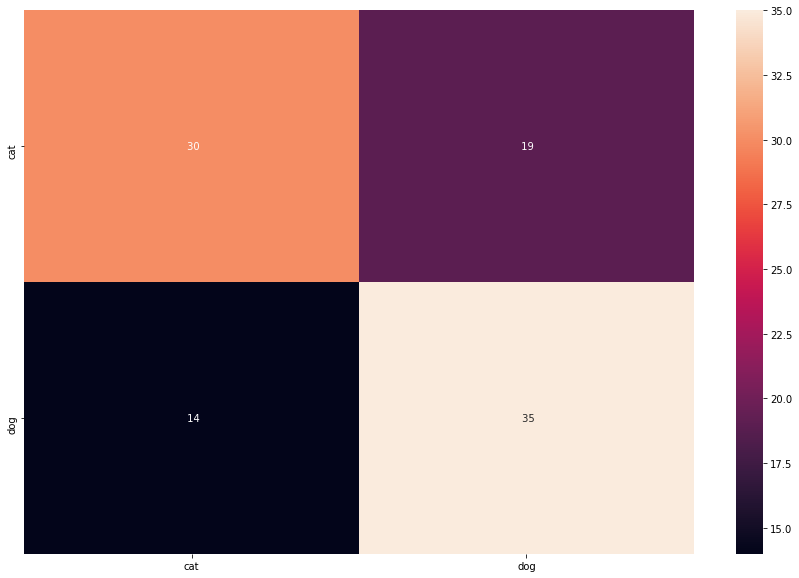

In [32]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(y_true, y_pred), fmt='3', annot=True, xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])

In [35]:
print('MCC: {}'.format(matthews_corrcoef(y_true, y_pred)))

MCC: 0.3282439759448873
